In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import nutils as utils
import visualize
from visualize import display_images
import nmodel as modellib
from nmodel import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Path to Shapes trained weights
# SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_shapes.h5")

# Path to Nuclei trained weights
NUCLEI_MODEL_PATH = os.path.join(MODEL_DIR, 'nuclei20180217T2339', "mask_rcnn_nuclei_0199.h5")

/Users/ralphtigoumo/anaconda2/envs/egpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

In [2]:
# Run one of the code blocks

# Shapes toy dataset
# import shapes
# config = shapes.ShapesConfig()

# MS COCO Dataset
import nuclei
config = nuclei.NucleiConfig()
NUCLEI_DIR = "../../input"
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               400
MEAN_PIXEL                     [44.57284587, 40.71265898, 48.6901747]
MINI_MASK_SHAPE                (28, 28)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_N

## Notebook Preferences

In [3]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "training"

In [4]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [5]:
# Build validation dataset
if config.NAME == 'shapes':
    dataset = shapes.ShapesDataset()
    dataset.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
elif config.NAME == "coco":
    dataset = coco.CocoDataset()
    dataset.load_coco(COCO_DIR, "minival")
elif config.NAME == "nuclei":
    dataset = nuclei.NucleiDataset()
    dataset.load_nuclei(NUCLEI_DIR, "train")
    dataset.prepare()
    
    dataset_train, dataset_val = dataset.extract_train_val()
    dataset_train.prepare()
    dataset_val.prepare()

# Must call before using the dataset
dataset_val.prepare()

print("Images: {}\nClasses: {}".format(len(dataset_val.image_ids), dataset_val.class_names))

Images: 34
Classes: ['BG', 'nu']


## Load Model

In [6]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode=TEST_MODE, model_dir=MODEL_DIR,
                              config=config)

# # Set weights file path
# if config.NAME == "shapes":
#     weights_path = SHAPES_MODEL_PATH
# elif config.NAME == "coco":
#     weights_path = COCO_MODEL_PATH
# elif config.NAME == "nuclei":
#     weights_path = NUCLEI_MODEL_PATH

# # Or, uncomment to load the last model you trained
# weights_path = model.find_last()[1]
# # weights_path = "/Users/ralphtigoumo/documents/kaggle/nuclei/solutions/kmrcnn/logs/nuclei20180227T1243/mask_rcnn_nuclei_0486.h5"
# # model.load_weights = load_weights
# # Load weights
# print("Loading weights ", weights_path)
# model.load_weights(weights_path, by_name=True)

## Run Detection

In [7]:
model.config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               400
MEAN_PIXEL                     [44.57284587, 40.71265898, 48.6901747]
MINI_MASK_SHAPE                (28, 28)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_N

In [8]:
g = modellib.data_generator(
    dataset_val, config, shuffle=False, batch_size=model.config.BATCH_SIZE)

In [13]:
[normalized_images, image_meta, rpn_anchors, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks], _ = next(g)

In [14]:
log("normalized_images", normalized_images)
log("image_meta", image_meta)
log("rpn_anchors", rpn_anchors)
log("rpn_match", rpn_match)
log("rpn_bbox", rpn_bbox)
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
inputs = [normalized_images, image_meta, rpn_anchors, rpn_match, 
          rpn_bbox, gt_class_ids, gt_boxes, gt_masks]
print(image_meta)

normalized_images        shape: (1, 520, 696, 3)      min:  -39.69017  max:   82.28734
image_meta               shape: (1, 10)               min:    0.00000  max:  696.00000
rpn_anchors              shape: (1, 90600, 4)         min:  -90.00000  max:  730.00000
rpn_match                shape: (1, 90600, 1)         min:   -1.00000  max:    1.00000
rpn_bbox                 shape: (1, 256, 4)           min:   -3.01768  max:    3.31456
gt_class_ids             shape: (1, 400)              min:    0.00000  max:    1.00000
gt_boxes                 shape: (1, 400, 4)           min:    0.00000  max:  649.00000
gt_masks                 shape: (1, 520, 696, 400)    min:    0.00000  max:  255.00000
[[  2 520 696   3   0   0 520 696   1   1]]


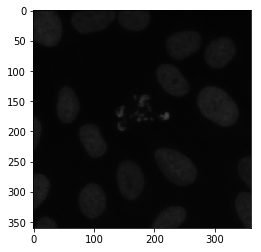

In [11]:
image = modellib.unmold_image(normalized_images, model.config)[0]
plt.imshow(image)

In [12]:
model.compile(0.0001,0.9)
outputs = model.keras_model.predict(inputs, verbose=1)
[rpn_class_logits, rpn_class, rpn_bbox,
 mrcnn_class_logits, mrcnn_class, mrcnn_bbox, mrcnn_mask,
 rpn_rois, output_rois,
 rpn_class_loss, rpn_bbox_loss, class_loss, bbox_loss, mask_loss] = outputs

Instructions for updating:
keep_dims is deprecated, use keepdims instead
1/1 [==============================] - 10s 10s/step


In [13]:
log("rpn_class_logits", rpn_class_logits)
log("rpn_class", rpn_class)
log("rpn_bbox", rpn_bbox)
log("mrcnn_class_logits", mrcnn_class_logits)
log("mrcnn_class", mrcnn_class)
log("mrcnn_bbox", mrcnn_bbox)
log("mrcnn_mask", mrcnn_mask)
log("rpn_rois", rpn_rois)
log("output_rois", output_rois)
log("rpn_class_loss", rpn_class_loss)
log("rpn_bbox_loss", rpn_bbox_loss)
log("class_loss", class_loss)
log("bbox_loss", bbox_loss)
log("mask_loss", mask_loss)

rpn_class_logits         shape: (1, 32502, 2)         min:  -36.01102  max:   38.39705
rpn_class                shape: (1, 32502, 2)         min:    0.00000  max:    1.00000
rpn_bbox                 shape: (1, 32502, 4)         min:  -38.36920  max:   28.07580
mrcnn_class_logits       shape: (1, 512, 2)           min:    0.25713  max:    2.75626
mrcnn_class              shape: (1, 512, 2)           min:    0.07592  max:    0.92408
mrcnn_bbox               shape: (1, 512, 2, 4)        min:   -2.12722  max:    2.57403
mrcnn_mask               shape: (1, 512, 28, 28, 2)   min:    0.29425  max:    0.65774
rpn_rois                 shape: (1, 2000, 4)          min:    0.00000  max:    0.00000
output_rois              shape: (1, 512, 4)           min:    0.00000  max:    0.00000
rpn_class_loss           shape: (1,)                  min:    6.27402  max:    6.27402
rpn_bbox_loss            shape: (1,)                  min:    9.01950  max:    9.01950
class_loss               shape: (1,)       

In [14]:
# Draw the detections
# TODO later. Need to implement the DetectionLayer.

## Step by Step Prediction

## Stage 0: Variable Inspection.
I'll just randomly inspect some variables here

In [ ]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    print("nms_node is None")
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
    print(nms_node)
rpn = model.run_graph(inputs, [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    # ("proposals", model.keras_model.get_layer("ROI").output),
    ("proposals", pillar)
])

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [12]:
target_rpn_match = rpn_match[0,:,0]
target_rpn_bbox = rpn_bbox[0]
# rpn_bbox.shape

In [13]:
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = rpn_anchors[positive_anchor_ix]
negative_anchors = rpn_anchors[negative_anchor_ix]
neutral_anchors = rpn_anchors[neutral_anchor_ix]

log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

image = modellib.unmold_image(normalized_images, model.config)[0]
log("image", image)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)

log("refined_anchors", refined_anchors, )

target_rpn_match         shape: (32502,)              min:   -1.00000  max:    1.00000
target_rpn_bbox          shape: (256, 4)              min:   -2.73983  max:    2.50000
positive_anchors         shape: (32, 4)               min:    0.00000  max:  384.00000
negative_anchors         shape: (224, 4)              min:  -22.62742  max:  384.00000
neutral anchors          shape: (32246, 4)            min:  -90.50967  max:  410.50967
image                    shape: (360, 360, 3)         min:    2.00000  max:   73.00000
refined_anchors          shape: (32, 4)               min:   -0.00000  max:  360.00003


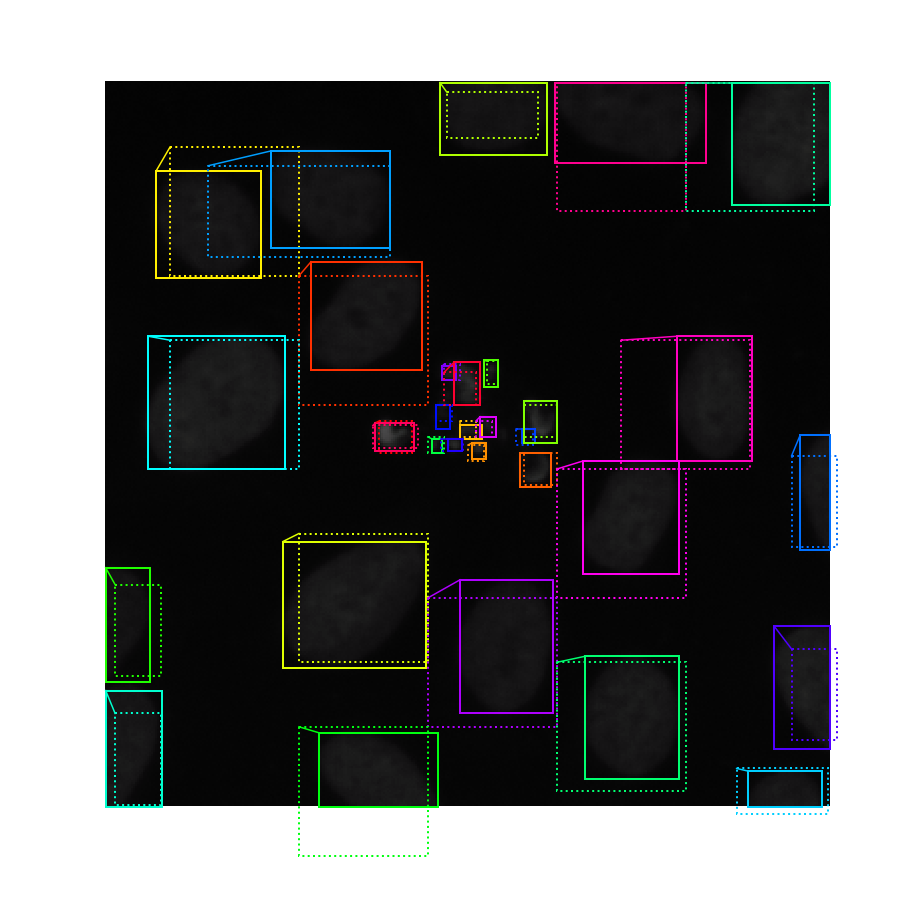

In [14]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [15]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    print("nms_node is None")
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
    print(nms_node)
rpn = model.run_graph(inputs, [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    # ("proposals", model.keras_model.get_layer("ROI").output),
    ("proposals", pillar)
])

nms_node is None
Tensor("ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0", shape=(?,), dtype=int32, device=/device:GPU:0)
rpn_class                shape: (1, 32502, 2)         min:    0.00000  max:    1.00000
pre_nms_anchors          shape: (1, 6000, 4)          min:  -90.50967  max:  410.50967
refined_anchors          shape: (1, 6000, 4)          min: -137.23715  max:  452.12677
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:  360.00000
post_nms_anchor_ix       shape: (2000,)               min:    0.00000  max: 4499.00000
proposals                shape: (1, 2000, 4)          min:    0.00000  max:    1.00000


In [16]:
rpn['rpn_class'][:,:,1][0].shape

(32502,)

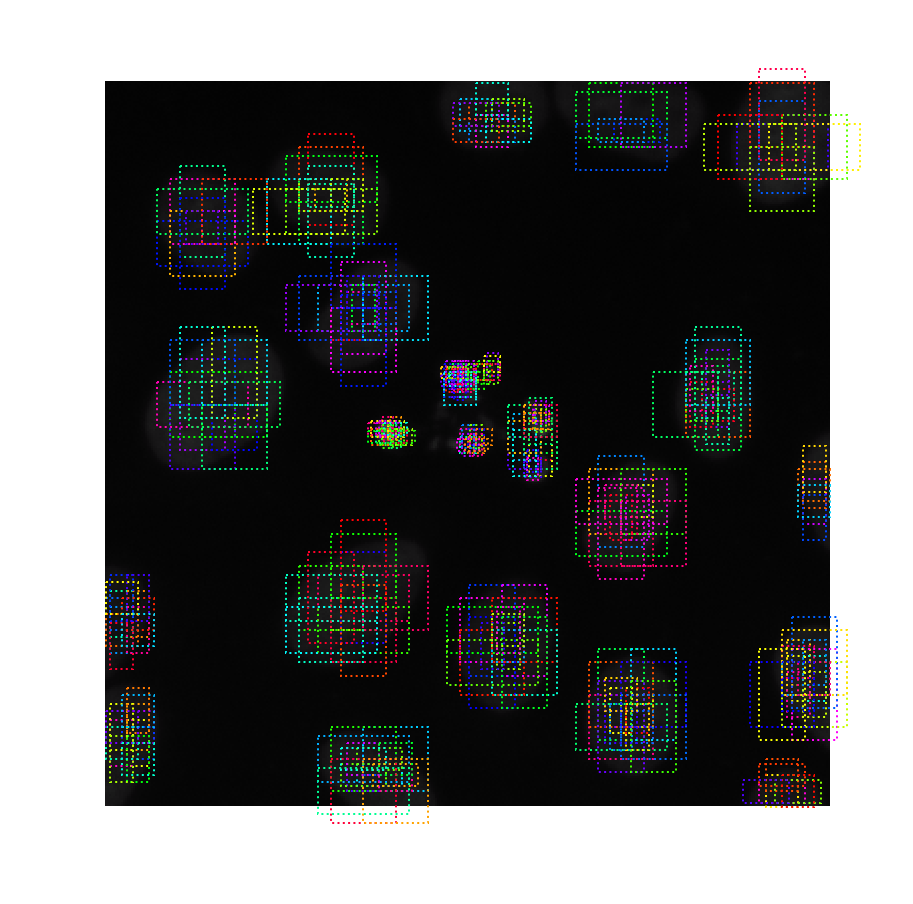

In [17]:
# Show top anchors by score (before refinement)
limit = 300
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1][0].flatten())[::-1]
visualize.draw_boxes(image, boxes=rpn_anchors[sorted_anchor_ids[:limit]], ax=get_ax())

In [18]:
rpn['refined_anchors_clipped'][0, :limit].shape

(300, 4)

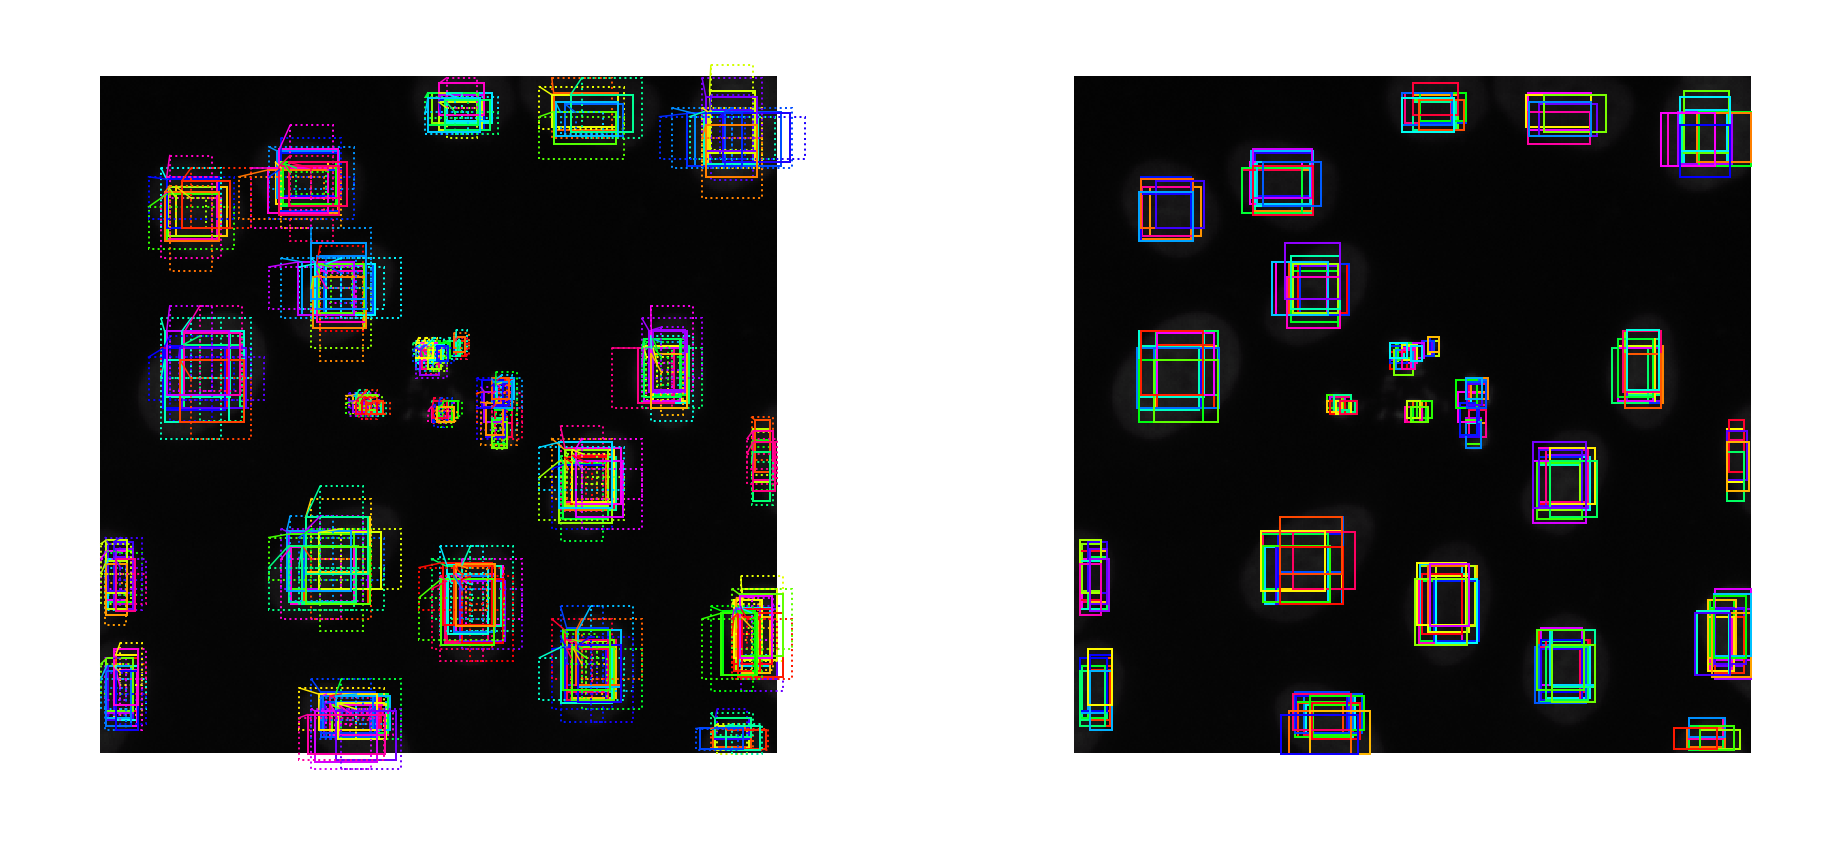

In [19]:
# Show top anchors with refinment. Then with clipping to image boundaries
limit = 300
ax = get_ax(1, 2)
visualize.draw_boxes(image, boxes=rpn["pre_nms_anchors"][0, :limit], 
           refined_boxes=rpn["refined_anchors"][0, :limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, :limit], ax=ax[1])

In [20]:
rpn["post_nms_anchor_ix"].shape

(2000,)

(300,)


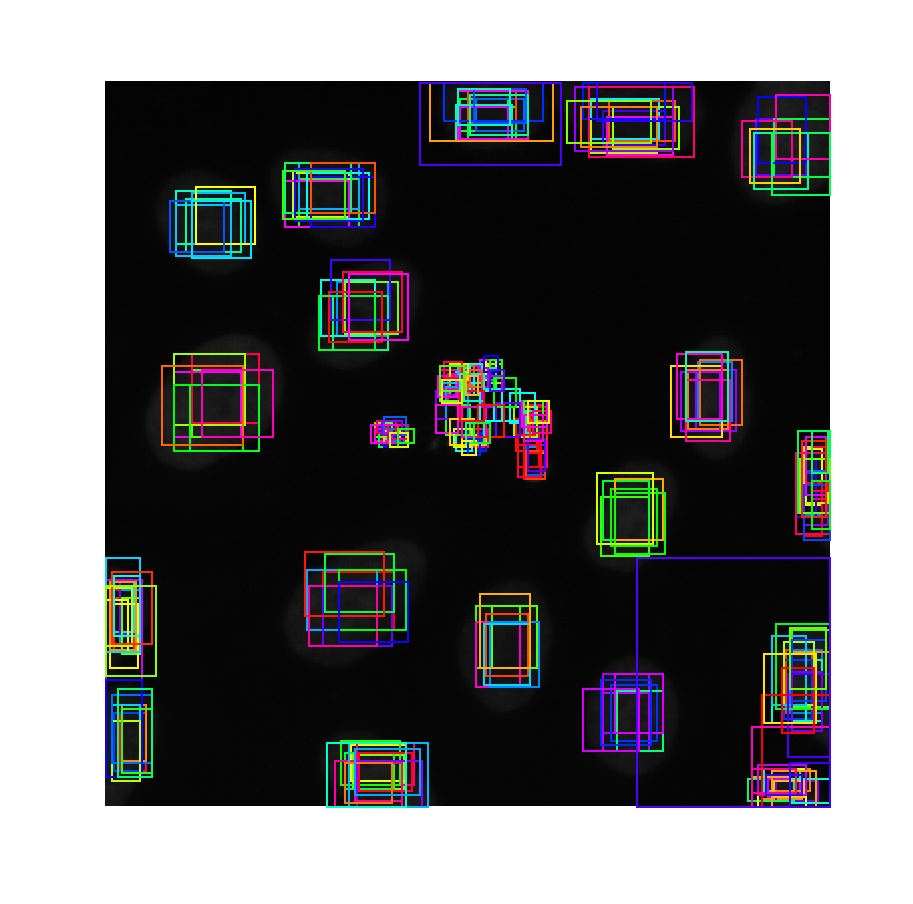

In [21]:
# Show refined anchors after non-max suppression
limit = 300
ixs = rpn["post_nms_anchor_ix"][:limit]
print(ixs.shape)
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, ixs], ax=get_ax())

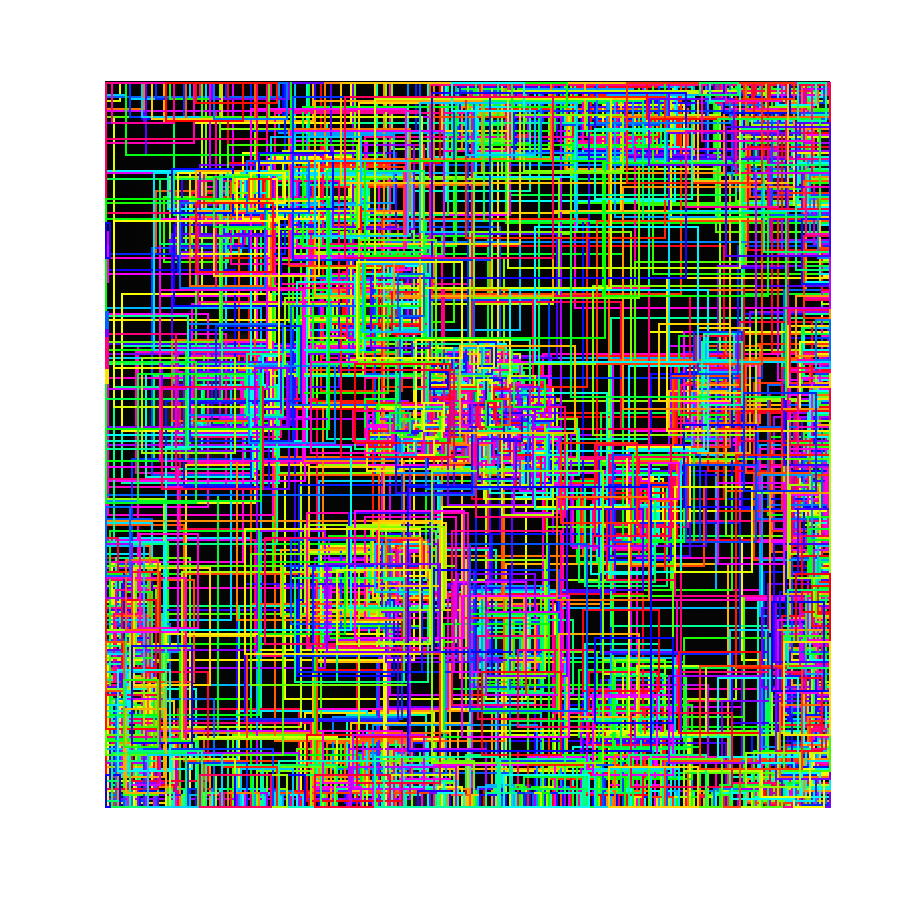

In [22]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 2000
# Convert back to image coordinates for display
h, w = image.shape[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

In [23]:
rpn_anchors.shape

(32502, 4)

In [24]:
# Measure the RPN recall (percent of objects covered by anchors)
# Here we measure recall for 3 different methods:
# - All anchors
# - All refined anchors
# - Refined anchors after NMS
iou_threshold = 0.7

recall, positive_anchor_ids = utils.compute_recall(rpn_anchors, gt_boxes[0], iou_threshold)
print("All Anchors ({:5})       Recall: {:.3f}  Positive anchors: {}".format(
    rpn_anchors.shape[0], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(rpn['refined_anchors'][0], gt_boxes[0], iou_threshold)
print("Refined Anchors ({:5})   Recall: {:.3f}  Positive anchors: {}".format(
    rpn['refined_anchors'].shape[1], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(proposals, gt_boxes[0], iou_threshold)
print("Post NMS Anchors ({:5})  Recall: {:.3f}  Positive anchors: {}".format(
    proposals.shape[0], recall, len(positive_anchor_ids)))


All Anchors (32502)       Recall: 0.013  Positive anchors: 6
Refined Anchors ( 6000)   Recall: 0.025  Positive anchors: 27
Post NMS Anchors ( 2000)  Recall: 0.018  Positive anchors: 12


In [25]:
gt_boxes.shape

(1, 400, 4)

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

In [72]:
# Get input and output to classifier and mask heads.
#1. Run DetectionTarget sub-graph
proposal_targets = model.keras_model.get_layer("proposal_targets").output
# rois_node = model.ancestor(pillar, "proposal_targets/rois:0")
# print(pillar)
proposal_targets = model.run_graph(inputs, [
    #("proposals", model.keras_model.get_layer("ROI").output),
    #("probs", model.keras_model.get_layer("mrcnn_class").output),
    #("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    #("masks", model.keras_model.get_layer("mrcnn_mask").output),
    # ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("rois", proposal_targets[0]),
    ("class_ids", proposal_targets[1]),
    ("bbox", proposal_targets[2]),
    ("mask", proposal_targets[3]),
])

rois                     shape: (2, 512, 4)           min:    0.00000  max:    1.00000
class_ids                shape: (2, 512)              min:    0.00000  max:    1.00000
bbox                     shape: (2, 512, 4)           min:   -3.22759  max:    2.69606
mask                     shape: (2, 512, 28, 28)      min:    0.00000  max:    1.00000


In [107]:
# np.where(proposal_targets['class_ids'][0]>0)[0].shape
proposal_targets['rois'][0][500:512]

array([[0.48319176, 0.23051411, 0.52167344, 0.2569392 ],
       [0.4412592 , 0.6191007 , 0.49416977, 0.6703938 ],
       [0.79565555, 0.91866714, 0.82020175, 0.96163017],
       [0.12723108, 0.99062395, 0.14031926, 0.9994928 ],
       [0.15253936, 0.8051007 , 0.20551151, 0.86572737],
       [0.53068125, 0.7090334 , 0.5684744 , 0.76362014],
       [0.42302492, 0.76644564, 0.45054382, 0.81212676],
       [0.82311624, 0.60891193, 0.8604234 , 0.6609329 ],
       [0.27381638, 0.6130231 , 0.32146886, 0.66529673],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]], dtype=float32)

In [ ]:
# Display positive boxes on the image
positive_idx = np.where(proposal_targets['class_ids'][0] == 0)[0]
# print(positive_idx)
rois = proposal_targets['rois'][0] * np.array([h,w,h,w])
rois = rois[positive_idx]
h, w = config.IMAGE_SHAPE[:2]
# rois = proposal_targets['rois'][0] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=rois, ax=get_ax())

## Stage 3: FPN Inspection

This stage inspects the FPN feature maps

In [78]:
fpn = model.run_graph(inputs, [
    ("p2", model.keras_model.get_layer("fpn_p2").output),
    ("p3", model.keras_model.get_layer("fpn_p3").output),
    ("p4", model.keras_model.get_layer("fpn_p4").output),
    ("p5", model.keras_model.get_layer("fpn_p5").output),
    ("p6", model.keras_model.get_layer("fpn_p6").output),
])

KeyboardInterrupt: 

In [37]:
fpn_up = model.run_graph(inputs, [
#     ("p2", model.keras_model.get_layer("fpn_p2").output),
#     ("p3", model.keras_model.get_layer("fpn_p3").output),
#     ("p4", model.keras_model.get_layer("fpn_p4").output),
    ("p5_size", model.keras_model.get_layer("fpn_c5p5").output),
    ("p5", model.keras_model.get_layer("fpn_p5upsampled").output),
])

p5_size                  shape: (1, 12, 12, 256)      min:  -17.50859  max:   21.78451
p5                       shape: (1, 24, 24, 256)      min:  -17.50859  max:   21.78451


In [15]:
# resnet = model.run_graph(inputs, [
#     ("c2", model.keras_model.get_layer("res2c_relu").output),
#     ("c3", model.keras_model.get_layer("res3d_relu").output),
#     ("c4", model.keras_model.get_layer("res4b22_relu").output),
#     ("c5", model.keras_model.get_layer("res5c_relu").output),
# ])
resnet = model.run_graph(inputs, [
    ("c2", model.keras_model.get_layer("res2c_out").output),
    ("c3", model.keras_model.get_layer("res3d_out").output),
    ("c4", model.keras_model.get_layer("res4"+chr(98+21)+"_out").output),
    ("c5", model.keras_model.get_layer("res5c_out").output),
])

c2                       shape: (1, 90, 90, 256)      min:    0.00000  max:   20.66189
c3                       shape: (1, 45, 45, 512)      min:    0.00000  max:   15.05244
c4                       shape: (1, 23, 23, 1024)     min:    0.00000  max:   27.21925
c5                       shape: (1, 12, 12, 2048)     min:    0.00000  max:   23.36082


In [ ]:
m_inputs = model.run_graph(inputs, [
    ("c2", model.keras_model.get_layer("input_image").output),
    ("c3", model.keras_model.get_layer("input_image_meta").output),
    # ("c3", model.keras_model.get_layer("input_anchors").output),
    # ("res_c1", model.keras_model.get_layer("conv1").output),
])

In [27]:
rpn_anchors.shape

(32502, 4)

In [28]:
modellib

<module 'nmodel' from '/Users/ralphtigoumo/Documents/kaggle/nuclei/solutions/kmrcnn/nmodel.py'>